In [1]:
# Parameters
data_url = "https://github.com/mmore500/hereditary-stratigraph-concept/blob/26405273f59455d45002ad0745a12689bb486b0e/binder/phylogenetic-inference/a=pairwise_mrca_estimates+source=nk_randomselection_seed7_pop100_mut.01_snapshot_5000.csv.gz"


In [2]:
import endomill
import itertools as it
from nbmetalog import nbmetalog as nbm


In [3]:
nbm.print_metadata()


context: ci
hostname: b71b4dff68d5
interpreter: 3.8.12 (default, Jan 15 2022, 18:39:47)  [GCC 7.5.0]
nbcellexec: 3
nbname: phylogeny_reconstruction_mill
nbpath: /opt/hereditary-stratigraph-concept/binder/phylogenetic-inference/phylogeny_reconstruction_mill.ipynb
revision: null
session: 95e577f7-339e-410c-8f99-96fc66db89ce
timestamp: 2022-03-07T16:49:48Z00:00




IPython==7.16.1
keyname==0.4.1
yaml==5.3.1
endomill==0.1.3
nbmetalog==0.2.6
re==2.2.1
ipython_genutils==0.2.0
logging==0.5.1.2
zmq==22.3.0
json==2.0.9
ipykernel==5.5.3


In [4]:
data_urls = [
    'https://github.com/mmore500/hereditary-stratigraph-concept/blob/26405273f59455d45002ad0745a12689bb486b0e/binder/phylogenetic-inference/a=pairwise_mrca_estimates+source=nk_lexicaseselection_seed110_pop165_mut.01_snapshot_500.csv.gz',
    'https://github.com/mmore500/hereditary-stratigraph-concept/blob/26405273f59455d45002ad0745a12689bb486b0e/binder/phylogenetic-inference/a=pairwise_mrca_estimates+source=nk_randomselection_seed7_pop100_mut.01_snapshot_5000.csv.gz',
    'https://github.com/mmore500/hereditary-stratigraph-concept/blob/26405273f59455d45002ad0745a12689bb486b0e/binder/phylogenetic-inference/a=pairwise_mrca_estimates+source=nk_sharingselection_seed10_pop100_mut.01_snapshot_5000.csv.gz',
    'https://github.com/mmore500/hereditary-stratigraph-concept/blob/26405273f59455d45002ad0745a12689bb486b0e/binder/phylogenetic-inference/a=pairwise_mrca_estimates+source=nk_tournamentselection_seed140_pop100_mut.01_snapshot_5000.csv.gz',
]

endomill.instantiate_over(
    parameter_packs=[
        {'data_url': data_url}
        for data_url in data_urls
    ],
)


detected executing.endomill.ipynb file
skipping instantiate_over


In [5]:
#define papermil parameters
data_url: str


In [6]:
import alifedata_phyloinformatics_convert as apc
from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor
from Bio import Phylo
from keyname import keyname as kn
from matplotlib import pyplot as plt
import numpy as np
from os.path import basename
import pandas as pd
import sys
from teeplot import teeplot as tp
from tqdm import tqdm


In [7]:
nbm.print_metadata()


context: ci
hostname: b71b4dff68d5
interpreter: 3.8.12 (default, Jan 15 2022, 18:39:47)  [GCC 7.5.0]
nbcellexec: 7
nbname: phylogeny_reconstruction_mill
nbpath: /opt/hereditary-stratigraph-concept/binder/phylogenetic-inference/phylogeny_reconstruction_mill.ipynb
revision: null
session: 95e577f7-339e-410c-8f99-96fc66db89ce
timestamp: 2022-03-07T16:49:49Z00:00




IPython==7.16.1
endomill==0.1.3
ipykernel==5.5.3
ipython_genutils==0.2.0
json==2.0.9
keyname==0.4.1
logging==0.5.1.2
nbmetalog==0.2.6
re==2.2.1
yaml==5.3.1
zmq==22.3.0
Bio==1.79
alifedata_phyloinformatics_convert==0.5.0
matplotlib==3.3.2
numpy==1.21.5
pandas==1.1.2
teeplot==0.2.0


In [8]:
df = pd.read_csv(
    f'{data_url}?raw=true',
    compression='gzip',
)

nbm.print_dataframe_synopsis(df)

data_filename = basename(data_url)

print(data_filename)


digest: 2503cc8a3ed7038ba092b636b2eec0c301318439fbc6df681b86e1ce15187147
manifest:
  Column Configuration: '                            18#     ex., actual_bits=63+actual_strata=63+bits_error=-1+differentia=1+policy=TaperedDepthProportionalResolution+resolution=31+target_bits=64'
  Differentia Bit Width: '                           3#      ex., 1'
  Generation Of MRCA Lower Bound (inclusive): '      66#     ex., 4736'
  Generation Of MRCA Upper Bound (exclusive): '      46#     ex., 5000'
  Generation of Taxon Compared From: '               4#      ex., 5000'
  Generation of Taxon Compared To: '                 4#      ex., 5001'
  MRCA Bound Confidence: '                           3#      ex., 0.96875'
  Rank of Earliest Detectable Mrca With: '           6#      ex., 512'
  Stratigraphic Column Actual Num Retained Strata: ' 12#     ex., 63'
  Stratigraphic Column Actual Retained Bits: '       13#     ex., 63'
  Stratigraphic Column Retained Bits Error: '        9#      ex., -1'
  Stra

In [9]:
endomill.add_instance_outpath(
    f'a=phylogeny_reconstruction+source={kn.unpack(data_filename)["source"]}.endomill.ipynb'
)


In [10]:
df['Treatment'] = df.apply(
    lambda row: kn.pack({
        'target': row['Stratigraphic Column Target Retained Bits'],
        'differentia': row['Differentia Bit Width'],
        'policy': row['Stratum Retention Policy'],
    }),
    axis=1,
)


In [11]:
max_gen = df['Generation of Taxon Compared From'].max()


In [12]:
def create_distance_matrix(df):
    assert len(df['Treatment'].unique() == 1)

    counter = it.count()
    taxon_to_index = {
        taxon : next(counter)
        for taxon in df['Taxon Compared From'].unique()
    }
    label_list = sorted(
        [*df['Taxon Compared From'].unique()],
        key=lambda x: taxon_to_index[x],
    )
    assert len(label_list) == len(taxon_to_index)
    distance_dict = {
        (taxon_to_index[row['Taxon Compared From']], taxon_to_index[row['Taxon Compared To']]):
            row['Generation of Taxon Compared From']
            - row['Generation Of MRCA Lower Bound (inclusive)']/2
            - row['Generation Of MRCA Upper Bound (exclusive)']/2
        for __, row in df.iterrows()
    }

    distance_matrix = np.array([
        [
            float(distance_dict[(i, j)] + distance_dict[(j, i)])
            if i != j
            else 0.0
            for j in range(len(taxon_to_index))
        ]
        for i in range(len(taxon_to_index))
    ])

    return distance_matrix, label_list


In [13]:
def to_tril(matrix):
    return [
        row[:row_idx] + [0]
        for row_idx, row in enumerate(matrix.tolist())
    ]


In [14]:
def construct_tree(df, algorithm):
    assert len(df['Treatment'].unique() == 1)
    distance_matrix, label_list = create_distance_matrix(df)
    np.nan_to_num(distance_matrix, nan=max_gen+1, copy=False)
    dm = DistanceMatrix([*map(str, label_list)], to_tril(distance_matrix))
    tree = getattr(DistanceTreeConstructor(), algorithm)(dm)
    return tree


In [15]:
trees = {
    (treatment, algorithm): construct_tree(group, algorithm)
    for treatment, group in tqdm(df.groupby('Treatment'))
    for algorithm in ('nj', 'upgma')
}


  0%|          | 0/18 [00:00<?, ?it/s]

  6%|▌         | 1/18 [00:01<00:25,  1.53s/it]

 11%|█         | 2/18 [00:03<00:24,  1.52s/it]

 17%|█▋        | 3/18 [00:04<00:22,  1.51s/it]

 22%|██▏       | 4/18 [00:05<00:20,  1.49s/it]

 28%|██▊       | 5/18 [00:07<00:19,  1.50s/it]

 33%|███▎      | 6/18 [00:09<00:18,  1.54s/it]

 39%|███▉      | 7/18 [00:10<00:16,  1.53s/it]

 44%|████▍     | 8/18 [00:12<00:15,  1.51s/it]

 50%|█████     | 9/18 [00:13<00:13,  1.52s/it]

 56%|█████▌    | 10/18 [00:15<00:12,  1.57s/it]

 61%|██████    | 11/18 [00:16<00:11,  1.60s/it]

 67%|██████▋   | 12/18 [00:18<00:09,  1.60s/it]

 72%|███████▏  | 13/18 [00:20<00:07,  1.58s/it]

 78%|███████▊  | 14/18 [00:21<00:06,  1.61s/it]

 83%|████████▎ | 15/18 [00:23<00:04,  1.60s/it]

 89%|████████▉ | 16/18 [00:24<00:03,  1.57s/it]

 94%|█████████▍| 17/18 [00:26<00:01,  1.55s/it]

100%|██████████| 18/18 [00:27<00:00,  1.55s/it]

100%|██████████| 18/18 [00:27<00:00,  1.55s/it]

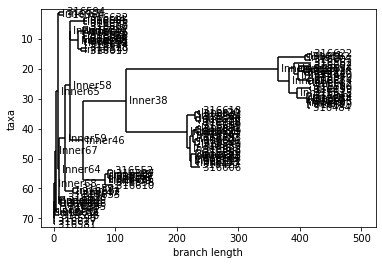

teeplots/algorithm=nj+treatment=differentia%1~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%1~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

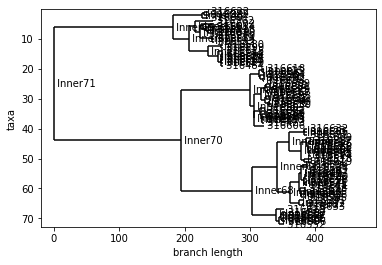

teeplots/algorithm=upgma+treatment=differentia%1~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%1~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

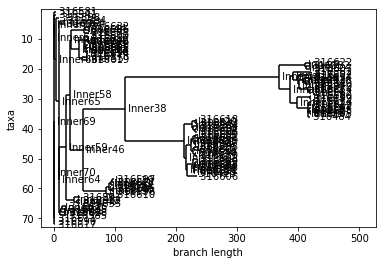

teeplots/algorithm=nj+treatment=differentia%1~policy%RecencyProportionalResolution~target%512+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%1~policy%RecencyProportionalResolution~target%512+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

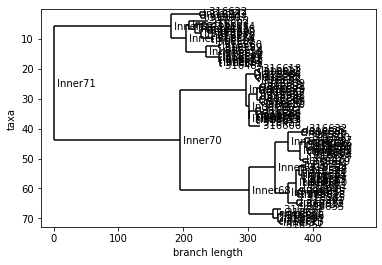

teeplots/algorithm=upgma+treatment=differentia%1~policy%RecencyProportionalResolution~target%512+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%1~policy%RecencyProportionalResolution~target%512+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

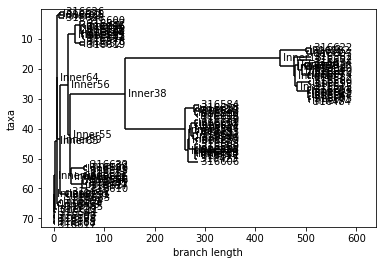

teeplots/algorithm=nj+treatment=differentia%1~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%1~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

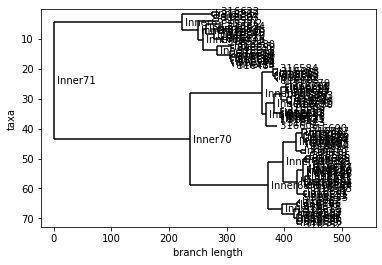

teeplots/algorithm=upgma+treatment=differentia%1~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%1~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

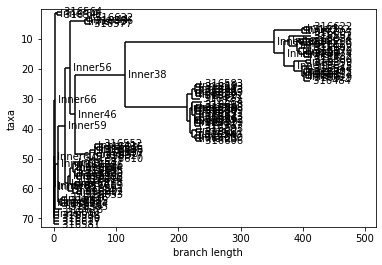

teeplots/algorithm=nj+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

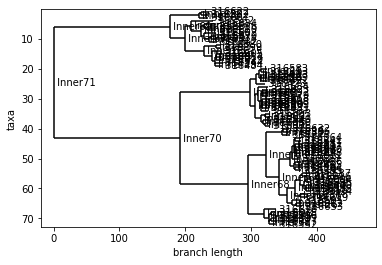

teeplots/algorithm=upgma+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

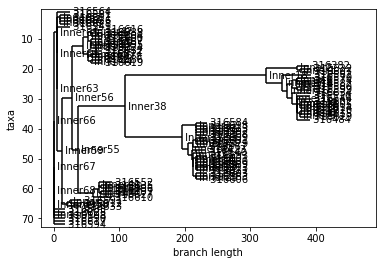

teeplots/algorithm=nj+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%512+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%512+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

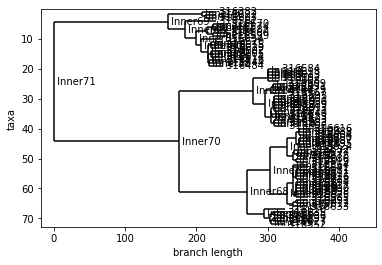

teeplots/algorithm=upgma+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%512+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%512+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

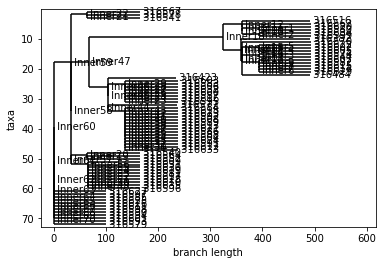

teeplots/algorithm=nj+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

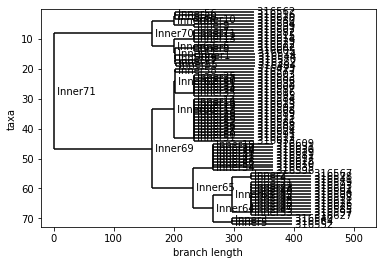

teeplots/algorithm=upgma+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

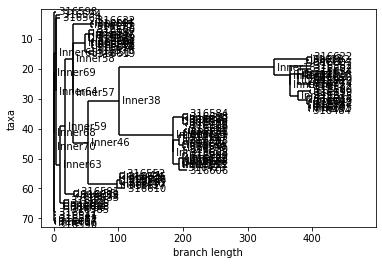

teeplots/algorithm=nj+treatment=differentia%64~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%64~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

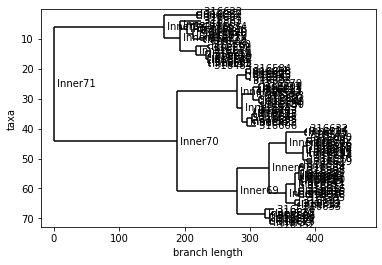

teeplots/algorithm=upgma+treatment=differentia%64~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%64~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

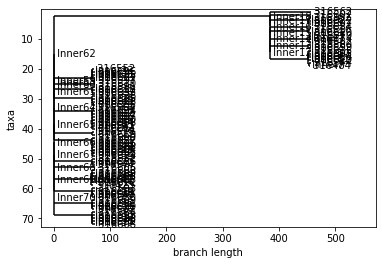

teeplots/algorithm=nj+treatment=differentia%64~policy%RecencyProportionalResolution~target%512+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%64~policy%RecencyProportionalResolution~target%512+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

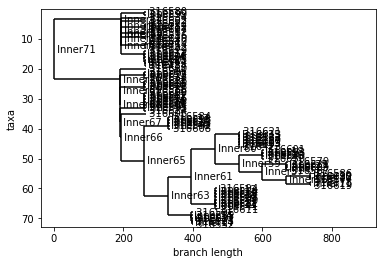

teeplots/algorithm=upgma+treatment=differentia%64~policy%RecencyProportionalResolution~target%512+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%64~policy%RecencyProportionalResolution~target%512+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

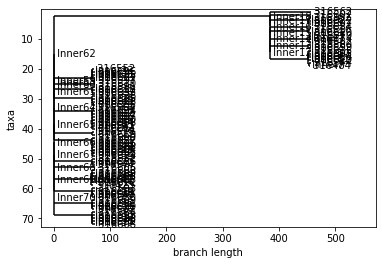

teeplots/algorithm=nj+treatment=differentia%64~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%64~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

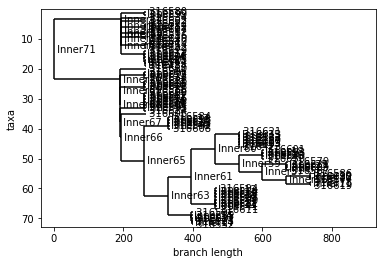

teeplots/algorithm=upgma+treatment=differentia%64~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%64~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

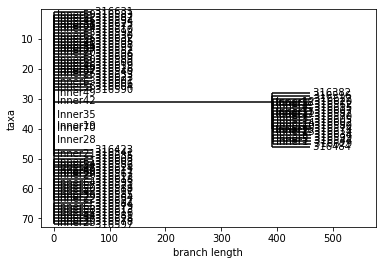

teeplots/algorithm=nj+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

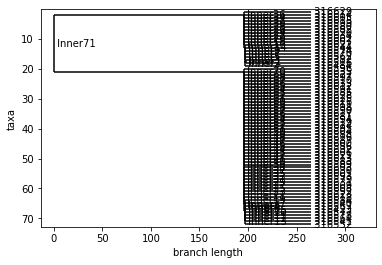

teeplots/algorithm=upgma+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

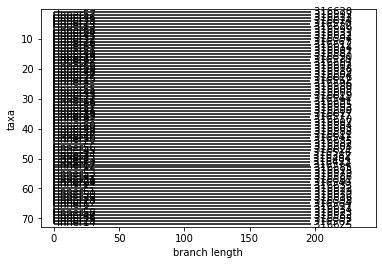

teeplots/algorithm=nj+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%512+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%512+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

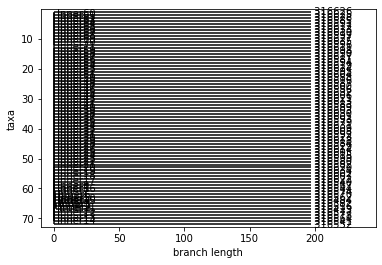

teeplots/algorithm=upgma+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%512+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%512+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

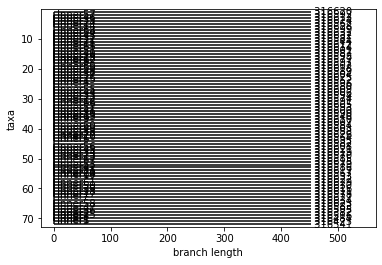

teeplots/algorithm=nj+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

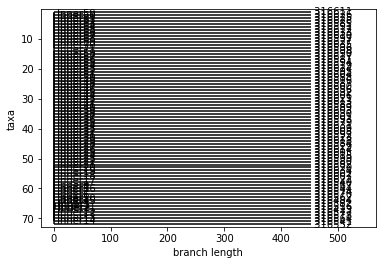

teeplots/algorithm=upgma+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

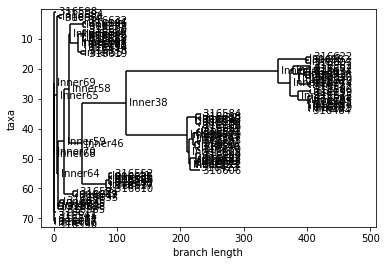

teeplots/algorithm=nj+treatment=differentia%8~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%8~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

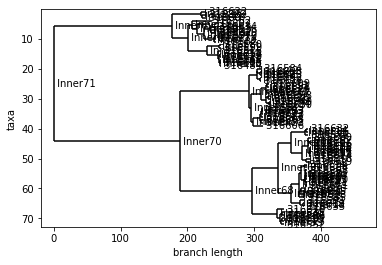

teeplots/algorithm=upgma+treatment=differentia%8~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%8~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

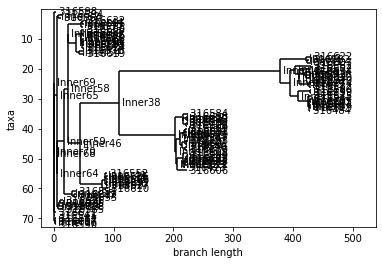

teeplots/algorithm=nj+treatment=differentia%8~policy%RecencyProportionalResolution~target%512+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%8~policy%RecencyProportionalResolution~target%512+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

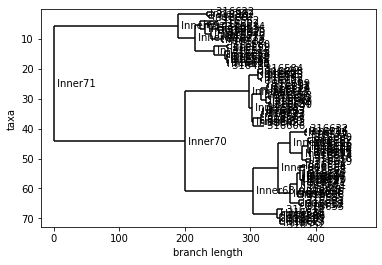

teeplots/algorithm=upgma+treatment=differentia%8~policy%RecencyProportionalResolution~target%512+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%8~policy%RecencyProportionalResolution~target%512+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

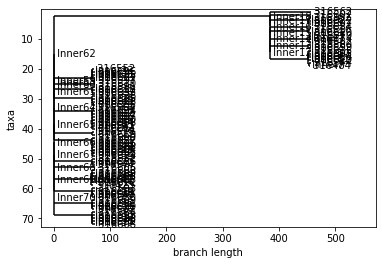

teeplots/algorithm=nj+treatment=differentia%8~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%8~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

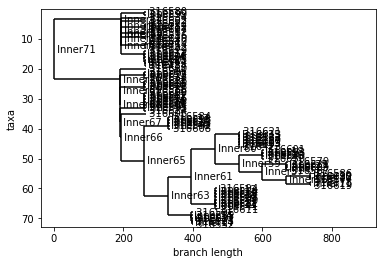

teeplots/algorithm=upgma+treatment=differentia%8~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%8~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

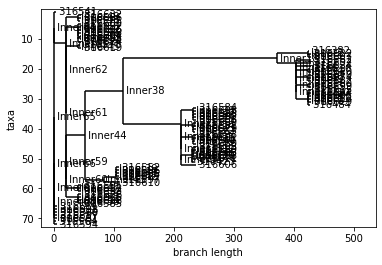

teeplots/algorithm=nj+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

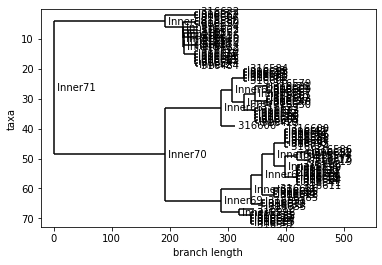

teeplots/algorithm=upgma+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

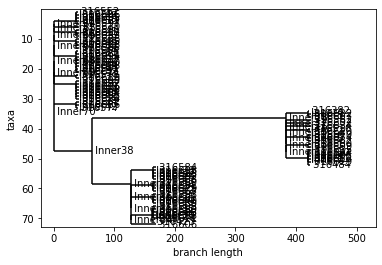

teeplots/algorithm=nj+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%512+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%512+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

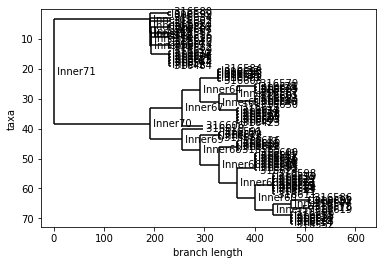

teeplots/algorithm=upgma+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%512+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%512+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

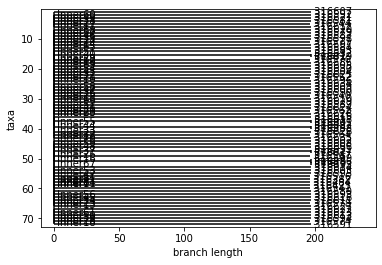

teeplots/algorithm=nj+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

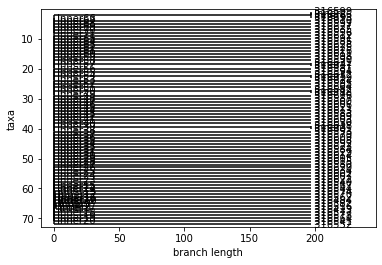

teeplots/algorithm=upgma+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

In [16]:
for (treatment, algorithm), tree in trees.items():
    tp.tee(
        Phylo.draw,
        tree,
        teeplot_outattrs={
            'algorithm' : algorithm,
            'treatment' : kn.demote(treatment),
        },
    )
    plt.show()


In [17]:
alife_dataframes = {
    (treatment, algorithm): apc.biopython_tree_to_alife_dataframe(tree)
    for (treatment, algorithm), tree in trees.items()
}
for (treatment, algorithm), df in alife_dataframes.items():
    df['Treatment'] = treatment
    df['Algorithm'] = algorithm


In [18]:
res_df = pd.concat(alife_dataframes.values()).reset_index()


In [19]:
res_df


,index,id,ancestor_list,origin_time,branch_length,name,Treatment,Algorithm
0,0,0,[None],0.000000,0.000000,Inner70,differentia=1+policy=RecencyProportionalResolu...,nj
1,1,1,[0],0.000000,0.000000,Inner69,differentia=1+policy=RecencyProportionalResolu...,nj
2,2,2,[1],2.000000,2.000000,Inner68,differentia=1+policy=RecencyProportionalResolu...,nj
3,3,3,[2],3.000000,1.000000,Inner67,differentia=1+policy=RecencyProportionalResolu...,nj
4,4,4,[3],7.000000,4.000000,Inner65,differentia=1+policy=RecencyProportionalResolu...,nj
...,...,...,...,...,...,...,...,...
5125,138,138,[118],197.000004,196.492188,316577,differentia=8+policy=TaperedDepthProportionalR...,upgma
5126,139,139,[117],197.000004,196.496094,316578,differentia=8+policy=TaperedDepthProportionalR...,upgma
5127,140,140,[116],197.000004,196.498047,316564,differentia=8+policy=TaperedDepthProportionalR...,upgma
5128,141,141,[115],197.000004,196.499023,316541,differentia=8+policy=TaperedDepthProportionalR...,upgma


In [20]:
nbm.print_dataframe_synopsis(res_df)


digest: 2290877a4cd5720ec55323c8b4a680b5369fe5c06c37c9194bf4ad90400ce91d
manifest:
  Algorithm: '     2#     ex., nj'
  Treatment: '     18#    ex., differentia=1+policy=RecencyProportionalResolution+target=1024'
  ancestor_list: ' 142#   ex., [None]'
  branch_length: ' 1483#  ex., 0.0'
  id: '            143#   ex., 0'
  index: '         143#   ex., 0'
  name: '          143#   ex., Inner70'
  origin_time: '   2264#  ex., 0.0'
num cols: 8
num cols all na: 0
num cols any na: 0
num na: 0
num rows: 5130
num rows all na: 0
num rows any na: 0
size: 1M



In [21]:
res_df.to_csv(
    f'a=reconstructed_phylogenies+source={kn.unpack(data_filename)["source"]}',
    compression='gzip',
)
